In [7]:
import tensorflow as tf
from keras.models import Sequential, Model
import numpy as np
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Embedding, Input, Attention, Flatten
import string
import datetime
import nltk
from nltk.tokenize import sent_tokenize,word_tokenize

In [8]:
dataset = open("sms.txt")


In [9]:
X=[]
Y=[]
vocabulario={}
translator = str.maketrans(dict.fromkeys(string.punctuation))
for linea in dataset:
    label,text=linea.strip().split("\t")
    text=text.translate(translator)
    message=[]
    for i in sent_tokenize(text):
        for j in word_tokenize(i):
            palabra=j.lower()
            message.append(palabra)
            if palabra in vocabulario:
                vocabulario[palabra]+=1
            else:
                vocabulario[palabra]=1
    X.append(message)
    y=[1] if label=="spam" else [0]
    Y.append(y)
print(len(vocabulario.keys()))

9636


In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

In [12]:
words=list(tokenizer.word_index.keys())
print(words)
vocabulary=len(words)+1
print(len(vocabulario.keys()))

['to', 'i', 'you', 'a', 'the', 'u', 'and', 'is', 'in', 'me', 'my', 'for', 'your', 'it', 'of', 'call', 'have', 'on', 'that', 'are', '2', 'now', 'im', 'not', 'so', 'but', 'or', 'can', 'at', 'do', 'ur', 'get', 'be', 'will', 'if', 'with', 'just', 'we', 'no', 'this', 'its', 'up', '4', 'dont', 'when', 'go', 'ok', 'from', 'free', 'all', 'out', 'how', 'what', 'know', 'got', 'like', 'ill', 'good', 'then', 'was', 'come', 'am', 'time', 'only', 'day', 'love', 'there', 'want', 'send', 'text', 'he', 'as', 'by', 'going', 'one', 'ü', 'need', 'about', 'txt', 'home', 'lor', 'see', 'sorry', 'still', 'r', 'back', 'stop', 'our', 'n', 'reply', 'today', 'mobile', 'tell', 'new', 'well', 'later', 'hi', 'think', 'been', 'da', 'she', 'any', 'please', 'take', 'they', 'her', 'phone', 'cant', 'did', 'some', 'here', 'has', 'week', 'night', 'an', 'claim', 'oh', 'who', 'much', 'great', 'hey', 'dear', 'him', 'more', 'pls', 'happy', 'na', 'd', 'too', 'hope', 'had', 'give', 'make', 'way', 'where', 'work', 'wat', 'should'

In [16]:
X = pad_sequences(sequences)

In [17]:
input_length=len(X[0])
print(vocabulary,input_length)
X=np.asarray(X)
Y=np.asarray(Y)

9637 171


In [18]:
x_train,x_val,y_train,y_val=train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=1)

Una vez que tenemos la secuencia de mensajes, el primer paso es crear un embedding que cree una representación vectorial de cada palabra de cada mensaje. Luego de eso agregamos la operación de atención. Esta
operación se caracteriza por analizar una secuencia candidata (el query: q) y compararla con un grupo de secuencias (las claves: k) y a partir de la similaridad de cada clave con secuencia candidata, genera como salida
una combinación lineal de los valores asociados a cada clave (cada clave k tiene asociado un vector de valor, v). Hay muchos tipos de antención, en este ejemplo estamos implementando la autoatención, en donde el query
(q), la clave (k) y el valor (v) son iguales. Esta operación lo que lograr es encontrar relaciones entre las palabras de cada frase para construir un significado, o equivalentemente, hacer la extracción de características
relevantes para efectuar posteriormente procesos de predicción o clasificación

In [21]:
d=64
input=Input(name="message",shape=(171,))
embedding=Embedding(input_dim=vocabulary,output_dim=64)(input)
q = Dense(name="wq",units=d)(embedding)
k = Dense(name="wk",units=d)(embedding)
v = Dense(name="wv",units=d)(embedding)
attention = Attention()([q, v, k])

Ahora completarmos nuestra red usando la extracción de características basada en atención para realizar el proceso de clasificación de mensajes.


In [22]:
hidden=Dense(d, activation='relu')(attention)
flatten=Flatten()(hidden)
hidden2=Dense(d,activation='relu')(flatten)
output=Dense(1, activation='sigmoid')(hidden2)
modelo=Model(inputs=input,outputs=output)
modelo.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ message             │ (None, 171)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 171, 64)   │    616,768 │ message[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ wq (Dense)          │ (None, 171, 64)   │      4,160 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ wv (Dense)          │ (None, 171, 64)   │      4,160 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ wk (Dense)          │ (None, 171, 64)   │      4,160 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 171, 64)   │          0 │ wq[0][0],         │
│ (Attention)         │                   │            │ wv[0][0],         │
│                     │                   │            │ wk[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 171, 64)   │      4,160 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 10944)     │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │    700,480 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,333,953 (5.09 MB)

 Trainable params: 1,333,953 (5.09 MB)

 Non-trainable params: 0 (0.00 B)

El proceso de entrenamiento será similar al que realizamos en el caso de las redes recurrentes. Una gran diferencia entre un Transformer y una red recurrente, es que el transformer procesa la entrada en paralelo al igual
que los perceptrones multicapa, por lo que tiene celdas de memoria como las redes LSTM.

In [23]:
modelo.compile(optimizer="Adam",loss="binary_crossentropy",metrics=["acc"])

In [24]:
tag="att"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
spam=modelo.fit(x_train,y_train,validation_data=(x_val,y_val),batch_size=32,epochs=4,verbose=2,
callbacks=[tensorboard_callback])

Epoch 1/4
140/140 - 6s - 41ms/step - acc: 0.9336 - loss: 0.1870 - val_acc: 0.9803 - val_loss: 0.0551
Epoch 2/4
140/140 - 4s - 26ms/step - acc: 0.9906 - loss: 0.0284 - val_acc: 0.9830 - val_loss: 0.0447
Epoch 3/4
140/140 - 4s - 28ms/step - acc: 0.9987 - loss: 0.0039 - val_acc: 0.9892 - val_loss: 0.0673
Epoch 4/4
140/140 - 4s - 29ms/step - acc: 0.9998 - loss: 7.6646e-04 - val_acc: 0.9865 - val_loss: 0.0567


In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
y_pred_probs=modelo.predict(x_val)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


Text(33.22222222222222, 0.5, 'Real')

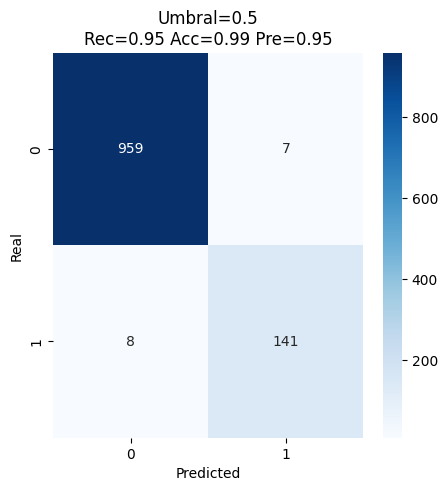

In [28]:
umbral=0.5
y_pred=y_pred_probs[:]>=umbral
fig, axes = plt.subplots(1,1)
fig.set_size_inches(5, 5)
matriz = confusion_matrix(y_val, y_pred)
ax=axes
sns.heatmap(matriz, annot=True, ax = ax, cmap="Blues",fmt="d");
ax.set_title("Umbral="+str(umbral)+"\nRec="+str(round(recall_score(y_val, y_pred),2))+
" Acc="+str(round(accuracy_score(y_val, y_pred),2))+
" Pre="+str(round(precision_score(y_val, y_pred),2)))
axes.set_xlabel('Predicted')
axes.set_ylabel('Real')